In [1]:
from pathlib import Path
import torch
from matplotlib import pyplot as plt
import numpy as np
from sainomore.data import copying
from sainomore.xai import ElissabethWatcher, get_alphabet_projection

from data import LetterAssembler

In [2]:
model_id = "3i8b4895"

In [3]:
assembler = LetterAssembler(Path("quotes.txt"))
config = {
    "context_length": assembler.context_length,
    "characters": assembler.vocab_size,
}

In [4]:
watcher = ElissabethWatcher.load(model_id, on_cpu=True)

## Model based

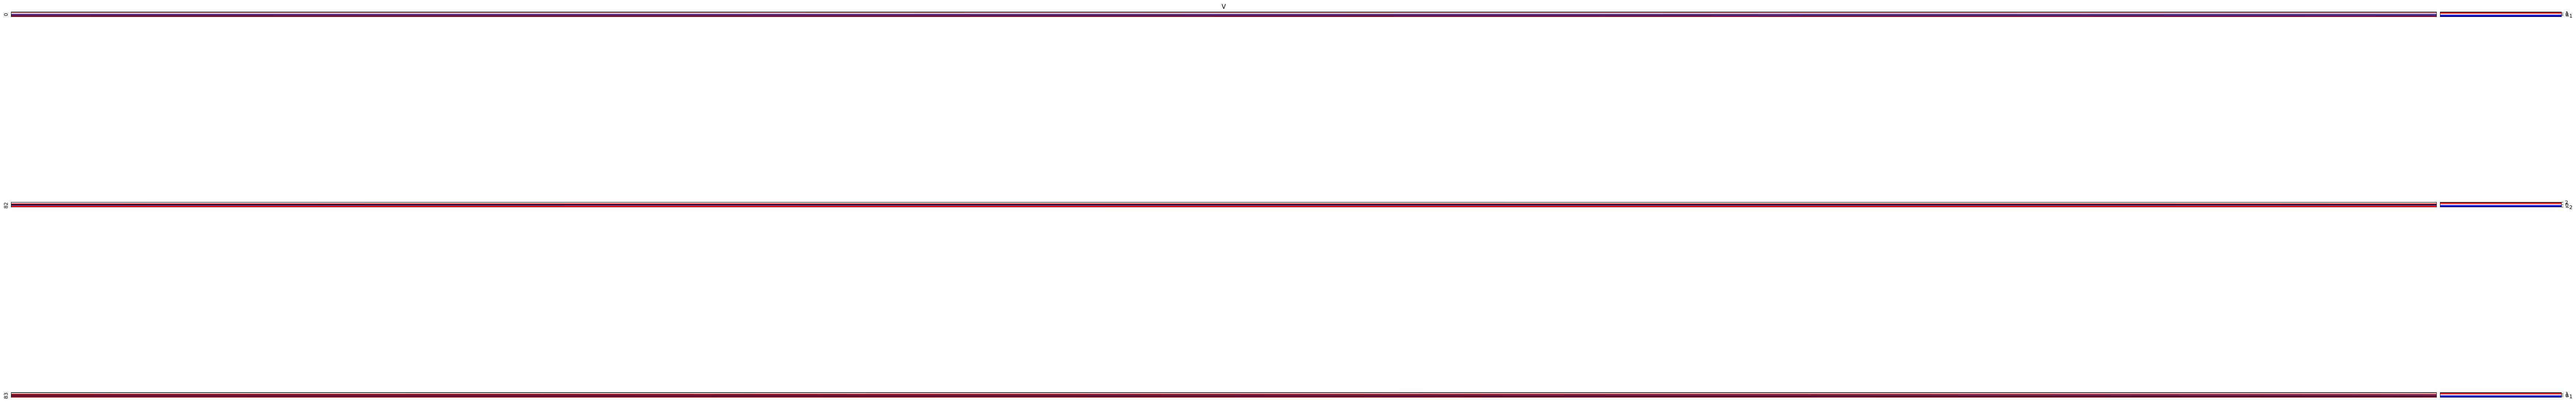

In [20]:
fig, ax = watcher.plot_alphabet_projection(
    q=False,
    k=False,
    v=True,
    n=4,
    tokens=torch.tensor([0, 82, 83]),
    transpose=True,
    figsize=(70, 20),
)
fig.savefig(
    f"copying_values_{model_id}.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)

In [ ]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.0.weight",
    figsize=(10, 5),
)
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.2.weight",
    # log_cmap=(0.1, 1.0),
    figsize=(10, 5),
)

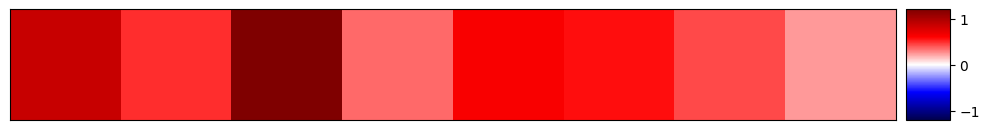

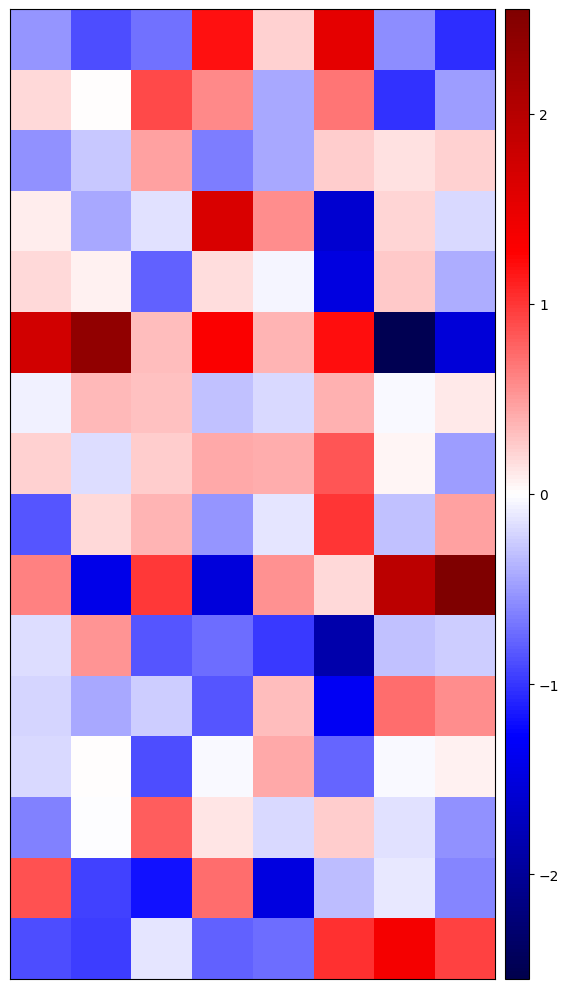

In [6]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_H",
    # reduce_dims={2: 0},
    # append_dims=(0,1,),
    figsize=(10, 10),
)
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_O",
    reduce_dims={2: 0},
    append_dims=(0,1,),
    figsize=(10, 10),
)

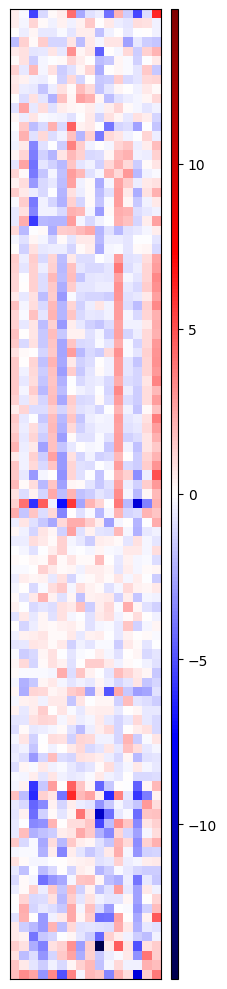

In [11]:
fig, ax = watcher.plot_parameter_matrix(
    "unembedding.weight",
    figsize=(10, 10),
)

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="q",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(25, 2),
)

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="k",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(20, 5),
)

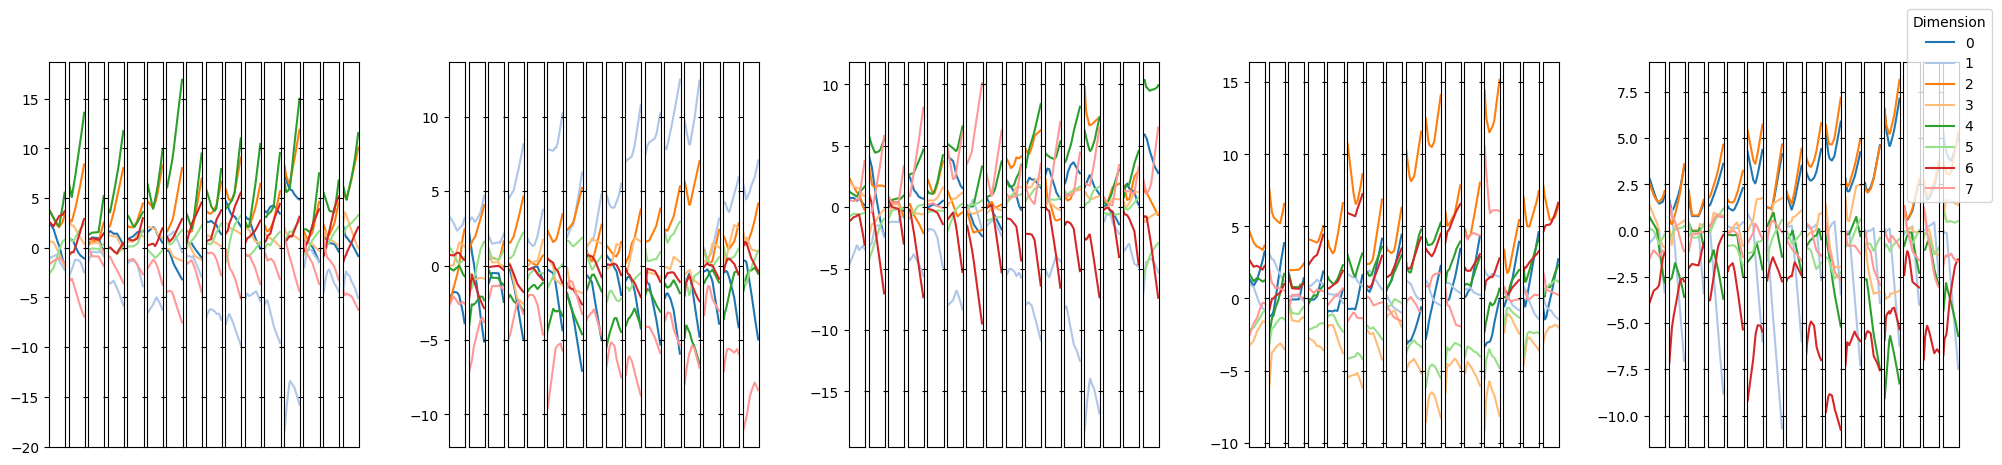

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="v",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2, ),
    figsize=(20, 5),
)

In [24]:
import json
with open("quotes.txt", encoding="utf-8") as f:
    file = f.readlines()
lengths = []
for line in file:
    lengths.append(len(line))
np.mean(lengths)

251.89017571884983

## Example based

In [5]:
def generate(start: str, n_tokens: int, temperature: float = 0.1) -> str:
    tensor = assembler.to_tensor(start, fill=False).unsqueeze(0)
    for _ in range(n_tokens):
        prob = torch.softmax(watcher.model(tensor)[:, -1:, :]/temperature, -1)
        tensor = torch.cat(
            (tensor, torch.multinomial(prob[:, 0, :], num_samples=1)),
            dim=1,
        )
    return assembler.translate(tensor[0])


In [6]:
generate("\{\"quote\":\"“Love is ", 10, temperature=0.5)

'{"quote":"“Love is aneande au'

In [5]:
torch.random.manual_seed(62)
np.random.seed(62)
x, y = assembler.sample()

In [6]:
x

tensor([[ 0, 82,  3,  ...,  0,  0,  0]])

In [22]:
assembler.translate(x[0][:26])

'{"quote":"“Love is the ab'

In [21]:
"".join(map(lambda x: assembler.itos.get(x, " "), watcher.model(x[:, :25]).argmax(-1)[0].numpy()))

'{"quote":"“Iene tn the tn'

In [11]:
fig, ax = watcher.plot_iss_time(
    x[0],
    x_axis=watcher.model(x).argmax(-1)[0, :],
    append_dims=(1, ),
    index_selection=((-1, torch.arange(100)), ),
    project_heads=False,
    project_values=False,
    figsize=(20, 20),
)
# fig, ax = watcher.plot_iss(
#     x[0],
#     append_dims=(1, ),
#     project_heads=True,
#     project_values=False,
#     figsize=(20, 20),
# )

Error in callback <function flush_figures at 0x0000026532509440> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [7]:
fig, ax = watcher.plot_query_key_time(
    x[0],
    weighting=0,
    names=("query", "key"),
    cmap="tab10",
    # x_axis=x[0],
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 30),
)

KeyError: "No hook named 'Q' found"

In [ ]:
watcher.model(torch.tensor([[0]])).shape

torch.Size([1, 1, 103])

In [ ]:
fig, ax = watcher.plot_values_time(
    x[0],
    x_axis=x[0],
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 5),
)

IndexError: index out of range in self

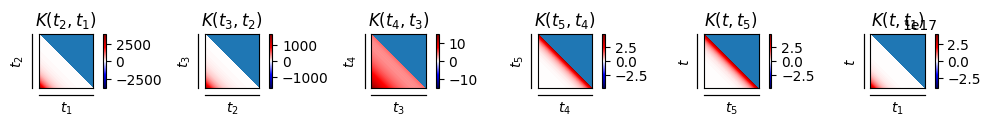

In [6]:
fig, ax = watcher.plot_attention_matrices(
    x[0],
    total=True,
    cmap="seismic",
    share_cmap=False,
    log_cmap=False,#(10, 1),
    causal_mask=True,
    only_kernels=None,
    project_heads=True,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    center_zero=True,
    cmap_example="tab20",
    figsize=(10, 10),
)
# fig.savefig(
#     f"attention_{model_id}.pdf",
#     facecolor=(0, 0, 0, 0),
#     bbox_inches="tight",
# )